# Dispensers by Status Last 24Hrs. TEST

In [379]:
from datetime import datetime, timezone, timedelta
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os
import pandas as pd
from sqlalchemy import create_engine

## Environment variables

Load environment variables and create url postgres conection

In [380]:
load_dotenv(".env")
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
database = os.getenv("POSTGRES_DB")

url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(url)


## Get database info

In [381]:
debug = True

Get current UTC time and subtract 24 hours

In [382]:
utc_now = datetime.now(timezone.utc)
utc_24h_before = utc_now - timedelta(hours=24)

Data input

In [383]:
organization_name = "Alabama A&M"
start_date = utc_24h_before.strftime('%Y-%m-%d %H:%M:%S')
end_date = utc_now.strftime('%Y-%m-%d %H:%M:%S')

In [384]:
if debug:
    print("start date:", start_date)
    print("end date:", end_date)

start date: 2025-05-27 21:30:15
end date: 2025-05-28 21:30:15


Get all rid units of the organization

In [385]:
query = "SELECT U.rid as rid "\
"FROM units.unit AS U "\
"LEFT JOIN \"authorization\".organization AS O "\
"ON U.id_organization = O.id "\
"WHERE O.name = '" + f"{organization_name}'"

if(debug):print(query)

SELECT U.rid as rid FROM units.unit AS U LEFT JOIN "authorization".organization AS O ON U.id_organization = O.id WHERE O.name = 'Alabama A&M'


In [386]:
df = pd.read_sql(query, con=engine)
df

,rid
0,RD31924
1,RD31920
2,RD31450
3,RD31916
4,RD31449
5,R125148
6,RC125145
7,RD31459
8,RD31436
9,R125146


Convert the result to a list to have into the format: ['RD01','RD02'] and check if array is empty

In [387]:
array = df['rid'].to_numpy().tolist()
if(debug):print(array)
if len(array) == 0:
    array_string = "NULL"
else:
    array_string = "ARRAY" + f"{array} "

['RD31924', 'RD31920', 'RD31450', 'RD31916', 'RD31449', 'R125148', 'RC125145', 'RD31459', 'RD31436', 'R125146', 'R125147', 'RD31919']


For each unit, we obtain its status with its own percentage.

In [388]:
query="SELECT status,sum(percentage) AS Percentage "\
"FROM get_percentage_duration("+f"'{start_date}',"+f"'{end_date}',"\
+ array_string +",NULL) "\
"GROUP BY status"

if(debug):print(query)

SELECT status,sum(percentage) AS Percentage FROM get_percentage_duration('2025-05-27 21:30:15','2025-05-28 21:30:15',ARRAY['RD31924', 'RD31920', 'RD31450', 'RD31916', 'RD31449', 'R125148', 'RC125145', 'RD31459', 'RD31436', 'R125146', 'R125147', 'RD31919'] ,NULL) GROUP BY status


In [389]:
df = pd.read_sql_query(query, con=engine)
df

,status,percentage
0,plugged in,3.244
1,available,40.670
2,charging,56.086


We calculate the total percentage of status by organization.

In [398]:
sumPercentage = df["percentage"].sum()
df["totalPercentage"] = round(((df["percentage"]* 100) / sumPercentage),3)

In [399]:
df1 = df.iloc[:,[0,2]]
df1

,status,totalPercentage
0,plugged in,3.244
1,available,40.670
2,charging,56.086


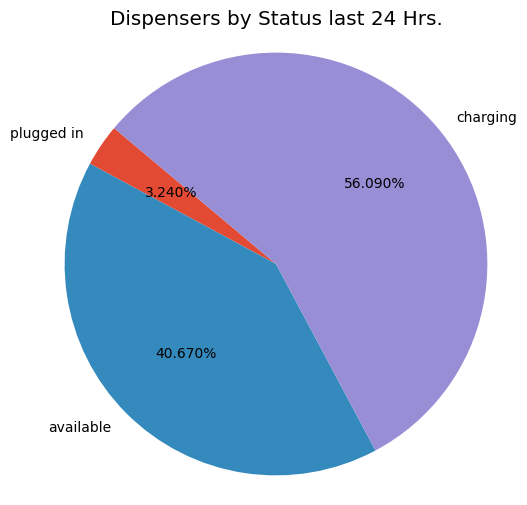

In [392]:
# Pie chart
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))
plt.pie(df1['totalPercentage'], labels=df1['status'], autopct='%1.3f%%', startangle=140)
plt.title('Dispensers by Status last 24 Hrs.')
plt.axis('equal')  # To be a circle
plt.show()

## Compare results

In [400]:
expectedPluggedIn = 3.244
expectedAvailable = 40.67
expectedDischarging = 0
expectedCharging = 56.086
df2 = pd.DataFrame(
    {
    "status": ['plugged in', 'available','discharging', 'charging'],
    "totalPercentage": [expectedPluggedIn, expectedAvailable, expectedDischarging, expectedCharging],
    }
)

df2 = pd.DataFrame(
    {
    "status": ['plugged in', 'available','charging'],
    "totalPercentage": [expectedPluggedIn, expectedAvailable, expectedCharging],
    }
)
df2



,status,totalPercentage
0,plugged in,3.244
1,available,40.670
2,charging,56.086


In [401]:
import pandas.testing as pdt
try:
    pdt.assert_frame_equal(df1, df2)
    print("SUCCESS: Data is the same.")
except AssertionError as e:
    print("FAIL: Data is different.")
    print(e)

SUCCESS: Data is the same.
